In [1]:
#!pip install wfdb
#!pip install torch-summary

Used image is: Pytorch 1.10 Python Python 3.8 GPU optimized.

On AWS kernel: ml.g4dn.xlarge (4 vCPU + 16 GiB + 1 GPU)

In [2]:
# Importing needed libraries
from matplotlib import pyplot as plt
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import random
from scipy.signal import resample_poly
from pickle import dump, load
import torch
import torch.nn as nn
from torch.utils import data
from torchsummary import summary
from sklearn.metrics import recall_score

import utils
from data_generator import dataset_gen
from model import lstm_model, cnn_lstm_model, unet_model, unet_inception_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Loading data

In [3]:
load_flag = False
if load_flag:
    # import files
    mitdb_records = get_record_list('mitdb')
    mitdb_signals, mitdb_beats, mitdb_beat_types = utils.data_from_records(mitdb_records, channel=0, db='mitdb')
    # save file
    dump(mitdb_signals, open('./mitdb_signals.pkl', 'wb'))
    dump(mitdb_beats, open('./mitdb_beats.pkl', 'wb'))
    dump(mitdb_beat_types, open('./mitdb_beat_types.pkl', 'wb'))
else:
    mitdb_signals = load(open('./mitdb_signals.pkl', 'rb'))
    mitdb_beats = load(open('./mitdb_beats.pkl', 'rb'))
    mitdb_beat_types = load(open('./mitdb_beat_types.pkl', 'rb'))


## Different R-peak types

In [4]:
# Extract beat symbols from all records
all_symbols = []
for symbols in mitdb_beat_types:
    all_symbols.append(symbols)
    
all_symbols = [item for sublist in all_symbols for item in sublist]
all_symbols = np.asarray(all_symbols)
u, c = np.unique(all_symbols, return_counts=True)

# Meanings for different heart beat codings
label_meanings = {
    "N": "Normal beat",
    "L": "Left bundle branch block beat",
    "R": "Right bundle branch block beat",
    "V": "Premature ventricular contraction",
    "/": "Paced beat",
    "A": "Atrial premature beat",
    "f": "Fusion of paced and normal beat",
    "F": "Fusion of ventricular and normal beat",
    "j": "Nodal (junctional) escape beat",
    "a": "Aberrated atrial premature beat",
    "E": "Ventricular escape beat",
    "J": "Nodal (junctional) premature beat",
    "Q": "Unclassifiable beat",
    "e": "Atrial escape beat",
    "S": "Supraventricular premature or ectopic"
}

# Print number of instances in each beat type
label_counts = [(label, count) for label, count in zip(u.tolist(), c.tolist())]
label_counts.sort(key=lambda tup: tup[1], reverse=True)
for label in label_counts:
    print(label_meanings[label[0]], "-"*(40-len(label_meanings[label[0]])), label[1])

Normal beat ----------------------------- 75052
Left bundle branch block beat ----------- 8075
Right bundle branch block beat ---------- 7259
Premature ventricular contraction ------- 7130
Paced beat ------------------------------ 7028
Atrial premature beat ------------------- 2546
Fusion of paced and normal beat --------- 982
Fusion of ventricular and normal beat --- 803
Nodal (junctional) escape beat ---------- 229
Aberrated atrial premature beat --------- 150
Ventricular escape beat ----------------- 106
Nodal (junctional) premature beat ------- 83
Unclassifiable beat --------------------- 33
Atrial escape beat ---------------------- 16
Supraventricular premature or ectopic --- 2


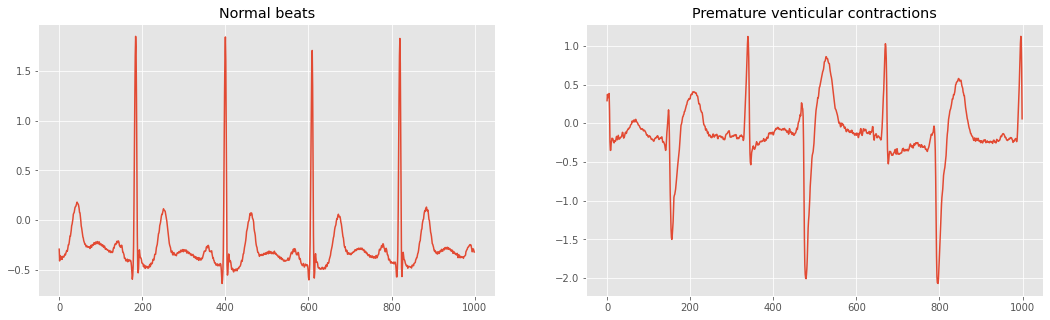

In [5]:
# Plot examples of beat types
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5), fig.set_figwidth(18)
ax1.plot(mitdb_signals[3][:1000])
ax1.set_title('Normal beats')
ax2.plot(mitdb_signals[23][:1000])
ax2.set_title('Premature venticular contractions')
plt.show()

## Converting character encodings to numerical

In [6]:
# Create dictionary that encodes characters as numerical
label_codings = {}
for i in range(0, len(label_counts)):
    if label_counts[i][0] == 'N':
        label_codings[label_counts[i][0]] = 1
    else:
        label_codings[label_counts[i][0]] = -1
label_codings

{'N': 1,
 'L': -1,
 'R': -1,
 'V': -1,
 '/': -1,
 'A': -1,
 'f': -1,
 'F': -1,
 'j': -1,
 'a': -1,
 'E': -1,
 'J': -1,
 'Q': -1,
 'e': -1,
 'S': -1}

In [7]:
# Save new numerical encodings as list
mitdb_labels = []
for beat_types in mitdb_beat_types:
    numerical_symbols = [label_codings[sym] for sym in beat_types]
    mitdb_labels.append(np.asarray(numerical_symbols))
    
mitdb_labels[:5]

[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([-1, -1, -1, ..., -1, -1, -1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([-1, -1, -1, ..., -1, -1, -1])]

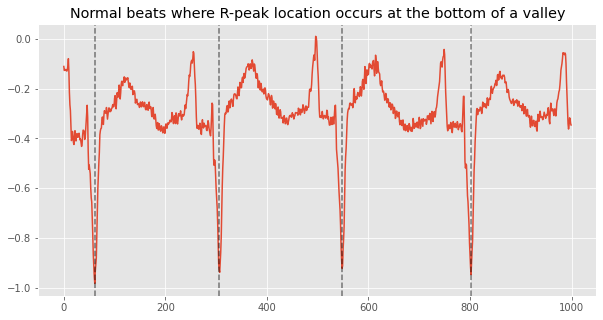

In [8]:
# Plot signal and beat locations as dashed line
plt.figure(figsize=(10,5))
plt.plot(mitdb_signals[8][:1000])
for peak in mitdb_beats[8][:4]:
    plt.axvline(x=peak, color='k', linestyle='--', alpha=0.5)
plt.title('Normal beats where R-peak location occurs at the bottom of a valley')
plt.show()

In [9]:
mitdb_labels = utils.fix_labels(mitdb_signals, mitdb_beats, mitdb_labels)

## Plot the noise

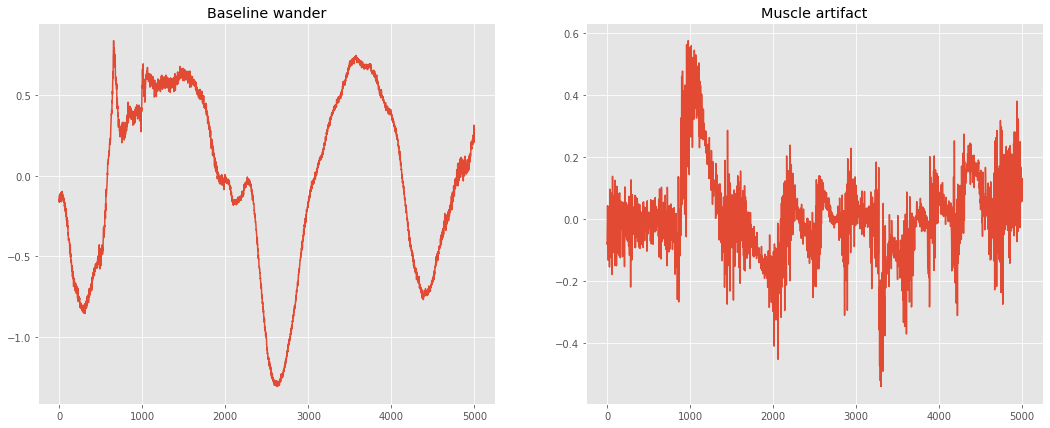

In [10]:
# Load data
baseline_wander = rdsamp('bw', pn_dir='nstdb')
muscle_artifact = rdsamp('ma', pn_dir='nstdb')

# Concatenate two channels to make one longer recording
ma = np.concatenate((muscle_artifact[0][:,0], muscle_artifact[0][:,1]))
bw = np.concatenate((baseline_wander[0][:,0], baseline_wander[0][:,1]))

# Resample noise to 250 Hz
ma = resample_poly(ma, up=250, down=muscle_artifact[1]['fs'])
bw = resample_poly(bw, up=250, down=baseline_wander[1]['fs'])

# Plot examples of baseline wandering and muscle artifact noise types
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7), fig.set_figwidth(18)
ax1.plot(bw[:5000])
ax1.set_title('Baseline wander')
ax2.plot(ma[:5000])
ax2.set_title('Muscle artifact')
plt.show()

## Create data loader

In [11]:
precent_train = 0.7

# create list of train and validation indexs
index_list = list(range(len(mitdb_signals)))
random.shuffle(index_list)
num_assets_train = int(precent_train * len(index_list))
index_train = index_list[:num_assets_train]
index_validation = index_list[num_assets_train:]

print('Number of examples in training is %d and in validation is %d' % (len(index_train),len(index_validation)))

Number of examples in training is 33 and in validation is 15


In [12]:
# Define Training Data
n_batch = 256
win_size = 1000

train_dataset = dataset_gen(signals=[mitdb_signals[i] for i in index_train], 
                            peaks=[mitdb_beats[i] for i in index_train], 
                            labels=[mitdb_labels[i] for i in index_train], 
                            ma=ma,
                            bw=bw,
                            win_size=win_size)

train_loader = data.DataLoader(train_dataset, 
                               batch_size=n_batch, 
                               shuffle=True)

# Define Validation Data
validation_dataset = dataset_gen(signals=[mitdb_signals[i] for i in index_validation], 
                            peaks=[mitdb_beats[i] for i in index_validation], 
                            labels=[mitdb_labels[i] for i in index_validation], 
                            ma=ma,
                            bw=bw,
                            win_size=win_size)

validation_loader = data.DataLoader(validation_dataset, 
                                    batch_size=n_batch, 
                                    shuffle=True)

## Build the model, loss, optimizer

In [13]:
# Define training parameters
output_size = 1
n_input_dim = 1
hidden_size = 64

# training hyper parameters
num_epochs = 200
l1_lambda = 0.001
fp_lambda = 1
positive_class_weight  = 20
negative_class_weight = 0.1

# define loss, optimizer and model
criterion = nn.BCELoss(reduction='none')
#model = lstm_model(n_input_dim, hidden_size, output_size).to(device)
#model = cnn_lstm_model(conv_input_dim=1, conv_kernel=[3,3,3,3,3], conv_feature = [16,32,32,16,1], hidden_size_lstm = 64).to(device)
#model = unet_model(conv_input_dim=1, conv_kernel = [3,3,3], conv_feature = [16,32,64], output_size = 1).to(device)
model = unet_inception_model(conv_input_dim = 1, conv_kernel_res = [15,17,19,21], conv_feature = [32,64,128,256], stride_size = [2,2,2,5], output_size = 1).to(device)

# optimizer
learning_rate = 0.001
weight_decay_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

# empty vectors for loss
train_loss_vec = np.zeros(num_epochs)
validation_loss_vec = np.zeros(num_epochs)

In [14]:
#summary(model, (1000,1))

## Training

In [15]:
for epoch in range(num_epochs):
    ##################
    ### TRAIN LOOP ###
    ##################
    # set the model to train mode, initiate training loss
    model.train()
    train_loss = 0
    
    for i,batch in enumerate(train_loader):
        # get batch images and labels
        X, y = batch
        
        # zero grad, predict
        optimizer.zero_grad()
        y_pred = model(X)
        
        # weighted BCE loss
        loss_class = criterion(y_pred,y)
        weight = negative_class_weight + y * (positive_class_weight - negative_class_weight)
        loss_class = loss_class * weight
        loss_class = loss_class.mean()
        
        # add L1 regularization 
        l1_norm = 0
        for param in model.parameters():
            l1_norm += torch.norm(param)
        
        # add false positive loss
        loss_fp = y_pred.mean()
        
        # sum losses
        loss = loss_class + l1_lambda * l1_norm + fp_lambda * loss_fp
        
        # backward and step
        loss.backward()
        optimizer.step()
        
        # accumulate the training loss, and print it
        train_loss += loss.item()
        #if i%1 == 0: print('Epoch %d, Train Batch %d/%d, loss: %.4f' % (epoch,i,len(train_loader),loss))

            
    #######################
    ### VALIDATION LOOP ###
    #######################
    # set the model to eval mode and initiate validation loss
    model.eval()
    valid_loss = 0
    
    # turn off gradients for validation
    with torch.no_grad():
        for i,batch in enumerate(validation_loader):
            # get batch images and labels
            X,y = batch
            
            # forward pass
            y_pred = model(X)
            
            # weighted BCE loss
            loss_class = criterion(y_pred,y)
            weight = negative_class_weight + y * (positive_class_weight - negative_class_weight)
            loss_class = loss_class * weight
            loss_class = loss_class.mean()
        
            # add L1 regularization 
            l1_norm = 0
            for param in model.parameters():
                l1_norm += torch.norm(param)
            
            # add false positive loss
            loss_fp = y_pred.mean()
            
            # sum losses
            loss = loss_class + l1_lambda * l1_norm + fp_lambda * loss_fp
        
            # accumulate the valid_loss and print it
            valid_loss += loss.item()
            #if i % 1 == 0: print('Epoch %d, Validation Batch %d/%d, loss: %.4f' % (epoch,i,len(validation_loader),loss))
                
                
    #########################
    ## PRINT EPOCH RESULTS ##
    #########################
    train_loss /= len(train_loader)
    valid_loss /= len(validation_loader)
    # update training and validation loss
    train_loss_vec[epoch] = train_loss
    validation_loss_vec[epoch] = valid_loss
    # print results
    print('Epoch: %s/%s: Training loss: %.3f. Validation Loss: %.3f.'
          % (epoch+1,num_epochs,train_loss,valid_loss))
    
    if (epoch+1) % 10 == 0:
        print('Weighted BCE loss is %.3f, FP loss is %.3f, L1 reg loss is %.3f' % (loss_class, fp_lambda * loss_fp, l1_lambda * l1_norm))


[2022-07-10 07:35:13.252 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:3669 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-10 07:35:13.410 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:3669 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


Epoch: 1/200: Training loss: 1.368. Validation Loss: 1.320.
Epoch: 2/200: Training loss: 1.167. Validation Loss: 1.313.
Epoch: 3/200: Training loss: 1.128. Validation Loss: 1.322.
Epoch: 4/200: Training loss: 1.083. Validation Loss: 1.305.
Epoch: 5/200: Training loss: 1.056. Validation Loss: 1.295.
Epoch: 6/200: Training loss: 1.035. Validation Loss: 1.305.
Epoch: 7/200: Training loss: 1.000. Validation Loss: 1.296.
Epoch: 8/200: Training loss: 1.001. Validation Loss: 1.266.
Epoch: 9/200: Training loss: 1.003. Validation Loss: 1.253.
Epoch: 10/200: Training loss: 1.007. Validation Loss: 1.239.
Weighted BCE loss is 0.349, FP loss is 0.540, L1 reg loss is 0.350
Epoch: 11/200: Training loss: 0.998. Validation Loss: 1.220.
Epoch: 12/200: Training loss: 0.976. Validation Loss: 1.178.
Epoch: 13/200: Training loss: 1.000. Validation Loss: 1.146.
Epoch: 14/200: Training loss: 1.001. Validation Loss: 1.134.
Epoch: 15/200: Training loss: 0.985. Validation Loss: 1.111.
Epoch: 16/200: Training los

## Print Single example

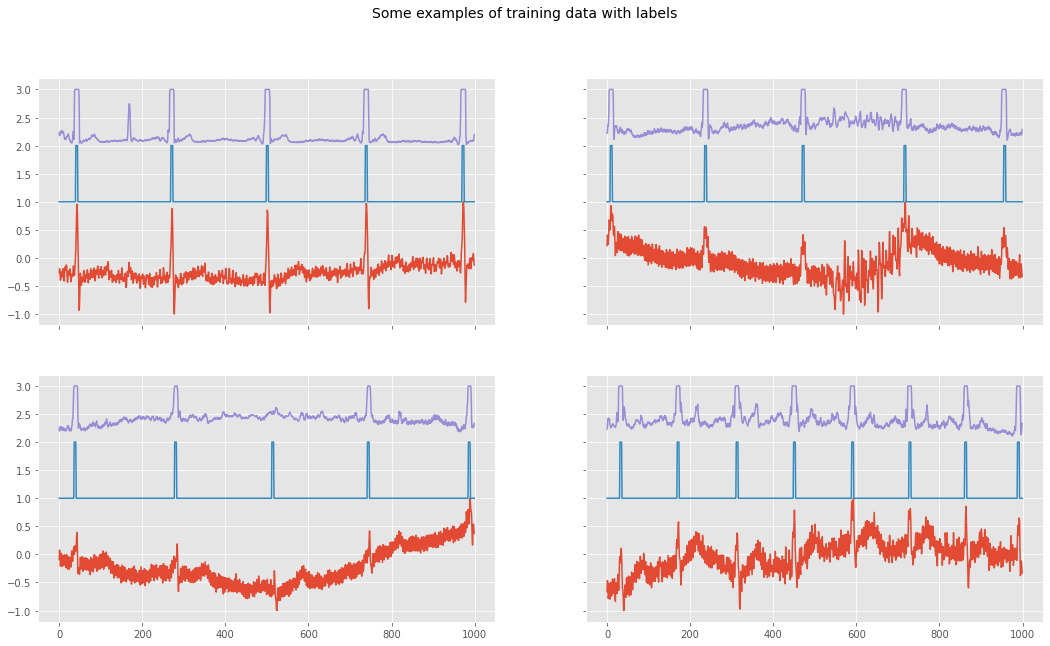

In [16]:
# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10), fig.set_figwidth(18)
fig.suptitle('Some examples of training data with labels', size=14)

# convet to cuda
X = X.cpu().numpy()
y = y.cpu().numpy()
y_pred = y_pred.cpu().numpy()


axs[0, 0].plot(X[0,:,:])
axs[0, 0].plot(y[0,:,:]+1)
axs[0, 0].plot(y_pred[0,:,:]+2)

axs[0, 1].plot(X[1,:,:])
axs[0, 1].plot(y[1,:,:]+1)
axs[0, 1].plot(y_pred[1,:,:]+2)

axs[1, 0].plot(X[2,:,:])
axs[1, 0].plot(y[2,:,:]+1)
axs[1, 0].plot(y_pred[2,:,:]+2)

axs[1, 1].plot(X[3,:,:])
axs[1, 1].plot(y[3,:,:]+1)
axs[1, 1].plot(y_pred[3,:,:]+2)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Plot losses

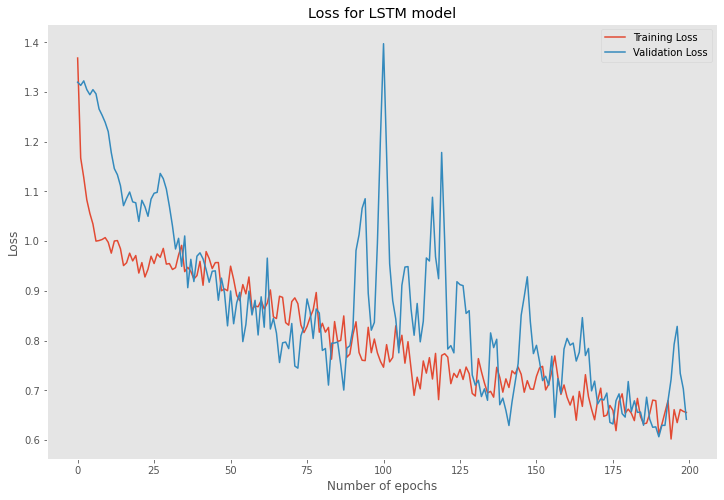

In [17]:
plt.figure(figsize = (12,8))
plt.plot(range(num_epochs),train_loss_vec,label='Training Loss')
plt.plot(range(num_epochs),validation_loss_vec,label='Validation Loss')
plt.grid(); plt.xlabel('Number of epochs'); plt.ylabel('Loss')
plt.title('Loss for LSTM model')
plt.legend()

## Evaluate model Recall and Specificity

In [18]:
model.eval()
valid_loss = 0
y = []
y_pred = []

# turn off gradients for evalute
with torch.no_grad():
    for i,batch in enumerate(validation_loader):
        # get batch images and labels
        X,y_batch = batch
        y_pred_batch = model(X)
        
        # save to vectore
        y.append(y_batch.cpu().flatten().tolist())
        y_pred.append(torch.round(y_pred_batch.cpu().flatten()).tolist())
        

# flat arrays
y = np.array([item for sublist in y for item in sublist]).astype(int)
y_pred = np.array([item for sublist in y_pred for item in sublist]).astype(int)   

In [19]:
# calculate recall and specificty
recall = recall_score(y, y_pred) * 100
specificty = recall_score(y, y_pred, pos_label = 0) * 100
print('For gqrs algorithm, Recall is %.3f and Specificity is %.3f' % (recall, specificty))

For gqrs algorithm, Recall is 95.422 and Specificity is 90.147


In [20]:
torch.save(model.state_dict(), './unet_inception_model.pt')